## Social graphs & intercations
- Assignment 2
- Submission date: November 4th 2025

### Group 101
- Aryan Mirzazadeh - s204489
- Juan Manuel Rodriguez - s253505 
- Vladyslav Horbatenko - s254355

### Contributions

- Aryan:
- Juan:
- Vlad:

# Part 1: Analyze the Network

## Introduction

This analysis examines a directed network of rock performers extracted from Wikipedia, where nodes represent bands or artists and directed edges indicate hyperlinks between their Wikipedia pages. The network contains 484 nodes and 7,323 directed edges. Each node has a `content_length` attribute indicating the character count of the corresponding Wikipedia page.

Using tools from Lecture 5, we characterize the network structure through visualization (using build in ForceAtlas2 method in `networkx` library), centrality measures (degree, betweenness, eigenvector), assortativity analysis, power-law distribution fitting, and network backbone extraction.

The directed nature of links in Wikipedia networks carries important semantic meaning. When band A links to band B, this connection reflects documented relationships such as shared tours, members, labels, or influences. However, the reverse link may not exist, creating asymmetry that distinguishes in-degree from out-degree. In-degree reflects prestige or fame, how many other pages mention a particular band. While out-degree reflects documentation scope of how comprehensively a band's own page documents related entities. This distinction is crucial because Wikipedia is opensource and edited by people, ith their own editorial choices, historical importance, and documentation practices.


## Data Setup

We load the rock band network from the pre-processed data file. The graph is a directed network where edges represent Wikipedia hyperlinks between artist pages. Isolated nodes have been removed, resulting in a single weakly connected component. We work with both the directed version (for in/out-degree analysis) and the undirected version (for centrality and other measures that require undirected graphs).


In [42]:
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gzip
import os
import requests
import io
from scipy import stats

In [43]:
local_network = "data/rock_graph_node_link.json.gz"
raw_url = f"https://raw.githubusercontent.com/rifolio/dtu-projects-2025-autumn/master/social-graphs/data/rock_graph_node_link.json.gz"

if os.path.exists(local_network):
    with gzip.open(local_network, "rt", encoding="utf-8") as fh:
        G_bands = nx.readwrite.node_link_graph(json.load(fh), edges="links")
else:
    r = requests.get(raw_url, timeout=30)
    r.raise_for_status()
    with gzip.open(io.BytesIO(r.content), "rt", encoding="utf-8") as fh:
        G_bands = nx.readwrite.node_link_graph(json.load(fh), edges="links")

# remove isolated nodes
isolated_nodes = list(nx.isolates(G_bands))
G_bands.remove_nodes_from(isolated_nodes)

print(f"Loaded directed graph with {G_bands.number_of_nodes()} nodes and {G_bands.number_of_edges()} edges.")
print(f"Isolated nodes removed: {len(isolated_nodes)}")
print(f"Graph component count: {len(list(nx.weakly_connected_components(G_bands)))}")

# making an undirected version
G_und = G_bands.to_undirected()
largest_cc = max(nx.connected_components(G_und), key=len)
G_gcc = G_und.subgraph(largest_cc).copy()

print(f"\nUndirected version: {G_und.number_of_nodes()} nodes and {G_und.number_of_edges()} edges")
print(f"Giant Connected Component: {G_gcc.number_of_nodes()} nodes and {G_gcc.number_of_edges()} edges")

Loaded directed graph with 484 nodes and 7323 edges.
Isolated nodes removed: 4
Graph component count: 1

Undirected version: 484 nodes and 6019 edges
Giant Connected Component: 484 nodes and 6019 edges


## Network Visualization with ForceAtlas2

Network visualization provides an intuitive representation of global structure that complements numerical measures. ForceAtlas2 just offers a more readable layout than traditional algorithms.

We visualize the network using NetworkX's built-in ForceAtlas2 layout algorithm as suggested in week5 lecture. In this plot, node size is proportional to degree, allowing prominent nodes with many connections to be easily seen, while node color represents the `content_length` attribute, roughly showing patterns in how bands are documented across the network.

In [44]:
pos_fa2 = nx.forceatlas2_layout(G_gcc, linlog=True, max_iter=500, seed=42)

/Users/aryanmirzazadeh/miniforge3/envs/sg/lib/python3.12/site-packages/networkx/drawing/layout.py:1809: RuntimeWarning: invalid value encountered in divide
  attraction = -np.log(1 + distance) / distance


In [45]:
# prep node attributes for visualization
degrees_gcc = dict(G_gcc.degree())
node_sizes = [degrees_gcc[n] * 7 for n in G_gcc.nodes()]  #  scale to have better visual representation (we decided to go with 7)
content_lengths = [G_gcc.nodes[n].get("content_length", 0) for n in G_gcc.nodes()]

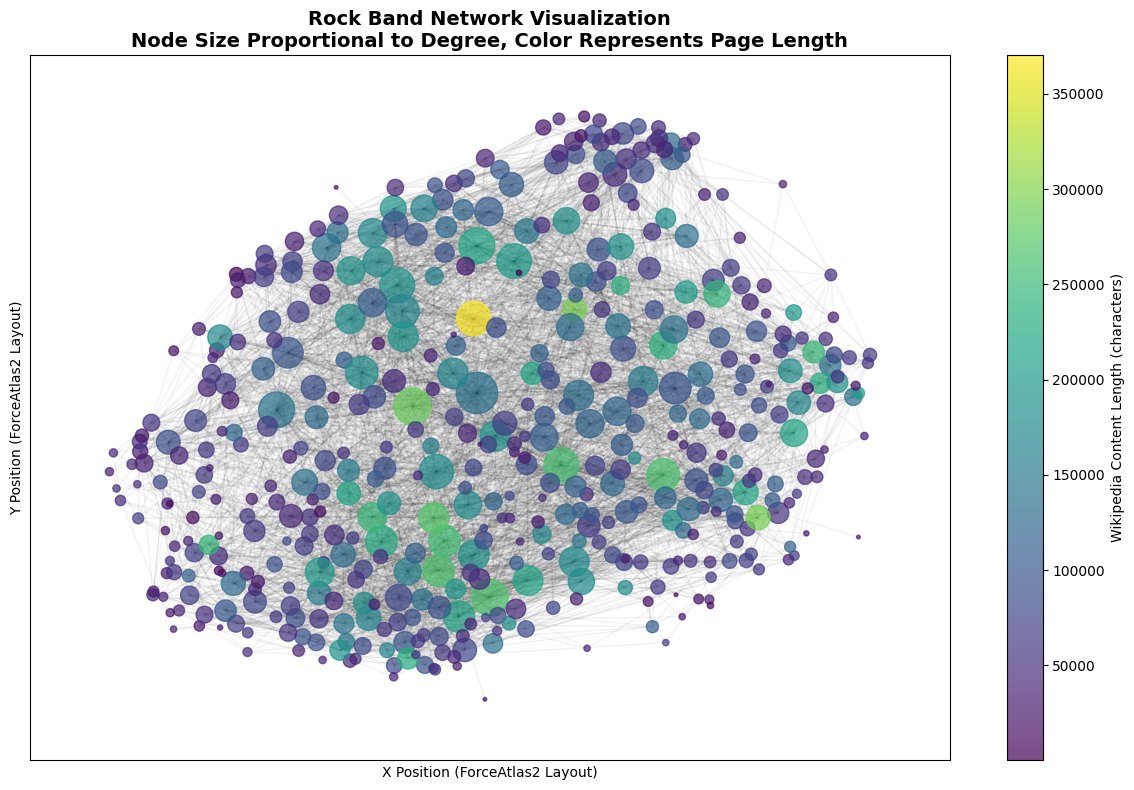

Visualization created with 484 nodes and 6019 edges


In [46]:
plt.figure(figsize=(12, 8))
nodes = nx.draw_networkx_nodes(
    G_gcc,
    pos_fa2,
    node_size=node_sizes,
    node_color=content_lengths,
    cmap=plt.cm.viridis,
    alpha=0.7
)
nx.draw_networkx_edges(G_gcc, pos_fa2, alpha=0.05, width=1, edge_color="black")

cbar = plt.colorbar(nodes, label="Wikipedia Content Length (characters)")
plt.xlabel("X Position (ForceAtlas2 Layout)")
plt.ylabel("Y Position (ForceAtlas2 Layout)")
plt.title(
    "Rock Band Network Visualization\nNode Size Proportional to Degree, Color Represents Page Length",
    fontsize=14,
    fontweight="bold"
)
plt.tight_layout()
plt.show()

print(f"Visualization created with {G_gcc.number_of_nodes()} nodes and {G_gcc.number_of_edges()} edges")


> **Figure 1** shows the network visualization using ForceAtlas2 layout. The spatial arrangement reveals clustering patterns and community structure, with larger nodes indicating bands that have more connections. The color gradient shows that bands with longer Wikipedia pages (warmer colors) are usually more connected in contrast with smaller and less connected pages, suggesting that documentation comprehensiveness and network position are related.


## Basic Network Structure

For directed networks such as Wikipedia, in-degree and out-degree must be analyzed separately because they capture different semantic meanings. In-degree reflects prestige or fame, how many other pages link to a particular band, indicating historical importance or influence. Out-degree reflects documentation scope, how comprehensively a band's own page documents related entities, which may be influenced by editorial practices and page comprehensiveness rather than historical importance alone.


In [47]:
# degree statistics for directed graph
in_degrees = dict(G_bands.in_degree())
out_degrees = dict(G_bands.out_degree())
in_deg_values = list(in_degrees.values())
out_deg_values = list(out_degrees.values())

In [48]:
def calculate_mode(values):
    mode_result = stats.mode(values, keepdims=True)
    return mode_result.mode[0] if len(mode_result.mode) > 0 else None

In [49]:
print("In-Degree Statistics:")
print(f"  Mode:   {calculate_mode(in_deg_values)}")
print(f"  Min:    {np.min(in_deg_values)}")
print(f"  Max:    {np.max(in_deg_values)}")
print(f"  Std Dev: {np.std(in_deg_values):.2f}")

print("\nOut-Degree Statistics:")
print(f"  Mode:   {calculate_mode(out_deg_values)}")
print(f"  Min:    {np.min(out_deg_values)}")
print(f"  Max:    {np.max(out_deg_values)}")
print(f"  Std Dev: {np.std(out_deg_values):.2f}")

In-Degree Statistics:
  Mode:   3
  Min:    0
  Max:    119
  Std Dev: 17.00

Out-Degree Statistics:
  Mode:   12
  Min:    0
  Max:    74
  Std Dev: 10.63


To get a better understanding lets also look at correlation and degree distribution

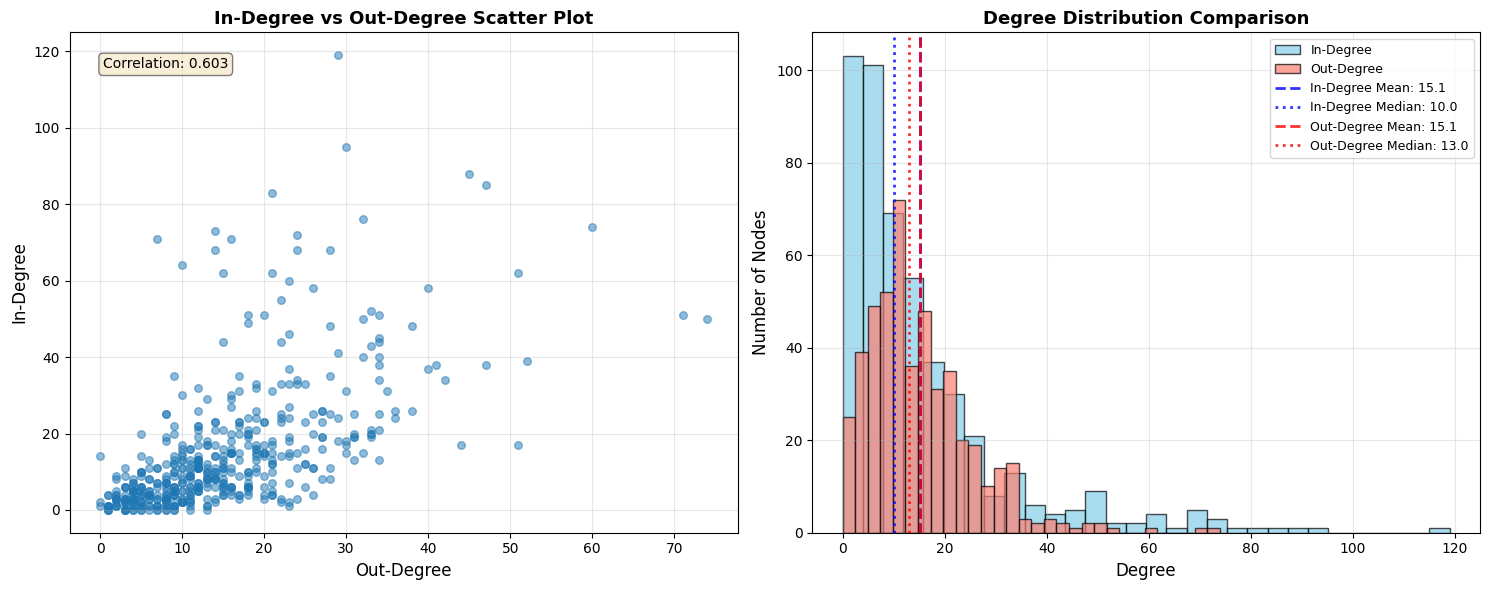

Correlation between in-degree and out-degree: 0.603


In [50]:
# calculate correlation
correlation = np.corrcoef(out_deg_values, in_deg_values)[0, 1]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# scatter plot
axes[0].scatter(out_deg_values, in_deg_values, alpha=0.5, s=30)
axes[0].set_xlabel("Out-Degree", fontsize=12)
axes[0].set_ylabel("In-Degree", fontsize=12)
axes[0].set_title("In-Degree vs Out-Degree Scatter Plot", fontsize=13, fontweight="bold")
axes[0].grid(True, alpha=0.3)

# correlation coefficient
axes[0].text(0.05, 0.95, f"Correlation: {correlation:.3f}", 
             transform=axes[0].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# histogram of degree distributions
axes[1].hist(in_deg_values, bins=30, alpha=0.7, label="In-Degree", color="skyblue", edgecolor="black")
axes[1].hist(out_deg_values, bins=30, alpha=0.7, label="Out-Degree", color="salmon", edgecolor="black")

# vertical lines for mean and median
in_mean = np.mean(in_deg_values)
in_median = np.median(in_deg_values)
out_mean = np.mean(out_deg_values)
out_median = np.median(out_deg_values)

axes[1].axvline(in_mean, color="blue", linestyle="--", linewidth=2, label=f"In-Degree Mean: {in_mean:.1f}", alpha=0.8)
axes[1].axvline(in_median, color="blue", linestyle=":", linewidth=2, label=f"In-Degree Median: {in_median:.1f}", alpha=0.8)
axes[1].axvline(out_mean, color="red", linestyle="--", linewidth=2, label=f"Out-Degree Mean: {out_mean:.1f}", alpha=0.8)
axes[1].axvline(out_median, color="red", linestyle=":", linewidth=2, label=f"Out-Degree Median: {out_median:.1f}", alpha=0.8)

axes[1].set_xlabel("Degree", fontsize=12)
axes[1].set_ylabel("Number of Nodes", fontsize=12)
axes[1].set_title("Degree Distribution Comparison", fontsize=13, fontweight="bold")
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Correlation between in-degree and out-degree: {correlation:.3f}")


> **Figure 2** shows the relationship between in-degree and out-degree through a scatter plot and histogram comparison. The degree statistics reveal that in-degree has mode 3, maximum 119, and standard deviation 17.00, while out-degree has mode 12, maximum 74, and standard deviation 10.63. Both distributions share mean values of 15.1, but their modes and medians differ significantly.
>
> The scatter plot reveals a moderate positive correlation (0.603), indicating that bands with many outgoing links tend to receive more incoming links. Most nodes are clustered near the origin, with 322 out of 484 nodes (66.5%) falling within the [0,20] × [0,20] degree range. However, there is a notable spread extending towards higher degrees, with some nodes reaching in-degrees up to nearly 120 and out-degrees up to around 70. The histogram comparison shows that while both distributions are right-skewed, out-degrees are slightly shifted towards higher values compared to in-degrees, suggesting that bands tend to document more related entities than they are referenced by others on average. This suggests that comprehensive documentation often correlates with greater recognition, though the imperfect correlation indicates these measures capture distinct aspects.

## Content Length and Documentation Patterns

Wikipedia page length, measured as the character count (`content_length`), reflects both editorial effort and overall importance. Understanding this relationship with degree measures helps to distinguish between whether longer pages result from more comprehensive documentation leading to more hyperlinks (correlating with out-degree), or whether more historically important bands receive longer, more detailed pages that naturally accumulate more incoming links (correlating with in-degree).

To assess these relationships, we compute both **Pearson correlation** and **Spearman correlation**. Pearson correlation measures linear relationships between variables, assuming normal distribution and detecting proportional changes. Spearman correlation measures monotonic relationships, ranking-based and more robust to outliers and non-linear but monotonic patterns. 

So, Pearson reveals whether longer pages systematically produce more links (linear relationship), while Spearman detects whether more comprehensive pages generally have more connections even if the relationship isn't perfectly linear (monotonic relationship).


In [51]:
# Analyze correlation between content_length and degrees
content_lengths_list = [G_bands.nodes[n].get("content_length", 0) for n in G_bands.nodes()]

# calculate correlations
corr_out = np.corrcoef(out_deg_values, content_lengths_list)[0, 1]
corr_in = np.corrcoef(in_deg_values, content_lengths_list)[0, 1]

# Spearman correlation (non-parametric)
spearman_out = stats.spearmanr(out_deg_values, content_lengths_list)[0]
spearman_in = stats.spearmanr(in_deg_values, content_lengths_list)[0]

print("Correlation between content_length and degrees:")
print(f"\nContent_length vs Out-degree:")
print(f"  Pearson correlation:  {corr_out:.4f}")
print(f"  Spearman correlation: {spearman_out:.4f}")

print(f"\nContent_length vs In-degree:")
print(f"  Pearson correlation:  {corr_in:.4f}")
print(f"  Spearman correlation: {spearman_in:.4f}")

Correlation between content_length and degrees:

Content_length vs Out-degree:
  Pearson correlation:  0.6337
  Spearman correlation: 0.6714

Content_length vs In-degree:
  Pearson correlation:  0.6627
  Spearman correlation: 0.6411


In [52]:
# TODO: Uncomment or delete?
# # visualizations
# fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# # Out-degree vs content_length
# axes[0].scatter(out_deg_values, content_lengths_list, alpha=0.5, s=30)
# axes[0].set_xlabel("Out-Degree", fontsize=12)
# axes[0].set_ylabel("Content Length (characters)", fontsize=12)
# axes[0].set_title(f"Out-Degree vs Content Length\n(Pearson: {corr_out:.3f}, Spearman: {spearman_out:.3f})", 
#                   fontsize=13, fontweight="bold")
# axes[0].grid(True, alpha=0.3)

# # In-degree vs content_length
# axes[1].scatter(in_deg_values, content_lengths_list, alpha=0.5, s=30)
# axes[1].set_xlabel("In-Degree", fontsize=12)
# axes[1].set_ylabel("Content Length (characters)", fontsize=12)
# axes[1].set_title(f"In-Degree vs Content Length\n(Pearson: {corr_in:.3f}, Spearman: {spearman_in:.3f})", 
#                   fontsize=13, fontweight="bold")
# axes[1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

> The Pearson correlation with in-degree (0.663) is slightly stronger than with out-degree (0.634), suggesting that historically important bands (those receiving many incoming links) tend to have longer Wikipedia pages, supporting the hypothesis that **fame drives page length**. However, both correlations are substantial, indicating that both **documentation scope (out-degree) and historical importance (in-degree) contribute to page length**. The Spearman correlations being similar to or slightly higher than Pearson correlations (especially for out-degree: 0.671 vs 0.634) suggests the relationships are robust and monotonic, not just linear. This indicates that more comprehensive Wikipedia pages generally have more connections, even if the relationship isn't perfectly proportional.


## Power-Law Distribution Analysis

We analyze the degree distributions for power-law properties to characterize the network structure and determine whether it exhibits scale-free properties, which can help us understand network behavior and identify the presence of hubs. We fit the distributions to power-law models and compare them with alternative distributions (log-normal and exponential). The results and their interpretation are discussed below.


In [53]:
import powerlaw

# Fit power-law to in-degree
fit_in = powerlaw.Fit(in_deg_values, discrete=True)
alpha_in = fit_in.alpha
xmin_in = fit_in.xmin

# Fit power-law to out-degree
fit_out = powerlaw.Fit(out_deg_values, discrete=True)
alpha_out = fit_out.alpha
xmin_out = fit_out.xmin

# Fit power-law to total degree (undirected)
total_degrees = dict(G_und.degree())
total_deg_values = list(total_degrees.values())
fit_total = powerlaw.Fit(total_deg_values, discrete=True)
alpha_total = fit_total.alpha
xmin_total = fit_total.xmin

print("Power-Law Exponents (alpha):")
print(f"  In-degree:  α = {alpha_in:.2f}, xmin = {xmin_in}")
print(f"  Out-degree: α = {alpha_out:.2f}, xmin = {xmin_out}")
print(f"  Total degree: α = {alpha_total:.2f}, xmin = {xmin_total}")


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Power-Law Exponents (alpha):
  In-degree:  α = 2.55, xmin = 15.0
  Out-degree: α = 3.87, xmin = 20.0
  Total degree: α = 3.39, xmin = 33.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


In [54]:
if 'fit_in' in locals():
    print("\nPower-Law vs Alternative Distributions (In-Degree):")
   
    R_in, p_in = fit_in.distribution_compare('power_law', 'lognormal', normalized_ratio=True)
    print(f"  Power-law vs Log-normal: R = {R_in:.2f}, p = {p_in:.4f}")

    R_in_exp, p_in_exp = fit_in.distribution_compare('power_law', 'exponential', normalized_ratio=True)
    print(f"  Power-law vs Exponential: R = {R_in_exp:.2f}, p = {p_in_exp:.4f}")



Power-Law vs Alternative Distributions (In-Degree):
  Power-law vs Log-normal: R = -2.41, p = 0.0161
  Power-law vs Exponential: R = -1.13, p = 0.2590


Results show distinct characteristics for each degree type:

- **In-degree** ($\alpha \approx 2.55$): Falls within the typical range of 2–3 for real-world networks, suggesting potential scale-free properties. However, comparison with alternative distributions reveals that **log-normal provides a significantly better fit** (R = -2.41, p = 0.0161). The negative R value and significant p-value indicate that log-normal distribution better characterizes the in-degree distribution than pure power-law.

- **Out-degree** ($\alpha \approx 3.87$): The steeper exponent indicates a distribution closer to exponential decay rather than power-law, suggesting limited scale-free properties.

- **Total degree** ($\alpha \approx 3.39$): Exhibits an intermediate exponent, reflecting the combined influence of both in-degree and out-degree patterns.

These findings indicate that **this network is better characterized by log-normal or truncated power-law distributions rather than pure power-laws**, particularly for in-degree. This aligns with research showing that many real-world networks previously thought to follow power-laws are better described as log-normal distributions when considering the full range of degrees rather than just the tail.


## Centrality Analysis: Multiple Perspectives on Node Importance

We compute four centrality measures (degree, betweenness, eigenvector, and closeness) to understand different aspects of node importance. These measures reveal distinct roles that nodes play in the network, and comparing them helps characterize the multifaceted nature of importance in this Wikipedia network. The results and their interpretation are discussed below.


In [55]:
# centrality measures on undirected graph
degree_cent = nx.degree_centrality(G_und)
betweenness_cent = nx.betweenness_centrality(G_und, normalized=True)
eigenvector_cent = nx.eigenvector_centrality(G_und, max_iter=1000, tol=1e-06)
closeness_cent = nx.closeness_centrality(G_und)

In [56]:
# top 5 nodes for each centrality measure
top_degree = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:5]
top_betweenness = sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)[:5]
top_eigenvector = sorted(eigenvector_cent.items(), key=lambda x: x[1], reverse=True)[:5]
top_closeness = sorted(closeness_cent.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 nodes by Degree Centrality:")
for i, (node, cent) in enumerate(top_degree, 1):
    print(f"{i}. {node:30s}: {cent:.4f}")

print("\nTop 5 nodes by Betweenness Centrality:")
for i, (node, cent) in enumerate(top_betweenness, 1):
    print(f"{i}. {node:30s}: {cent:.4f}")

print("\nTop 5 nodes by Eigenvector Centrality:")
for i, (node, cent) in enumerate(top_eigenvector, 1):
    print(f"{i}. {node:30s}: {cent:.4f}")

print("\nTop 5 nodes by Closeness Centrality:")
for i, (node, cent) in enumerate(top_closeness, 1):
    print(f"{i}. {node:30s}: {cent:.4f}")

Top 5 nodes by Degree Centrality:
1. Led Zeppelin                  : 0.2629
2. Queen (band)                  : 0.2070
3. Bob Dylan                     : 0.2070
4. Deep Purple                   : 0.1988
5. Metallica                     : 0.1988

Top 5 nodes by Betweenness Centrality:
1. Led Zeppelin                  : 0.0464
2. Bob Dylan                     : 0.0375
3. Queen (band)                  : 0.0310
4. Deep Purple                   : 0.0293
5. Jimi Hendrix                  : 0.0260

Top 5 nodes by Eigenvector Centrality:
1. Led Zeppelin                  : 0.1726
2. Metallica                     : 0.1535
3. Black Sabbath                 : 0.1522
4. Queen (band)                  : 0.1457
5. Deep Purple                   : 0.1453

Top 5 nodes by Closeness Centrality:
1. Led Zeppelin                  : 0.5565
2. Queen (band)                  : 0.5433
3. Bob Dylan                     : 0.5397
4. David Bowie                   : 0.5343
5. Deep Purple                   : 0.5337


In [57]:
# centrality values
degree_values = list(degree_cent.values())
betweenness_values = list(betweenness_cent.values())
eigenvector_values = list(eigenvector_cent.values())
closeness_values = list(closeness_cent.values())

# Calculate correlations
corr_db = np.corrcoef(degree_values, betweenness_values)[0, 1]
corr_de = np.corrcoef(degree_values, eigenvector_values)[0, 1]
corr_dc = np.corrcoef(degree_values, closeness_values)[0, 1]

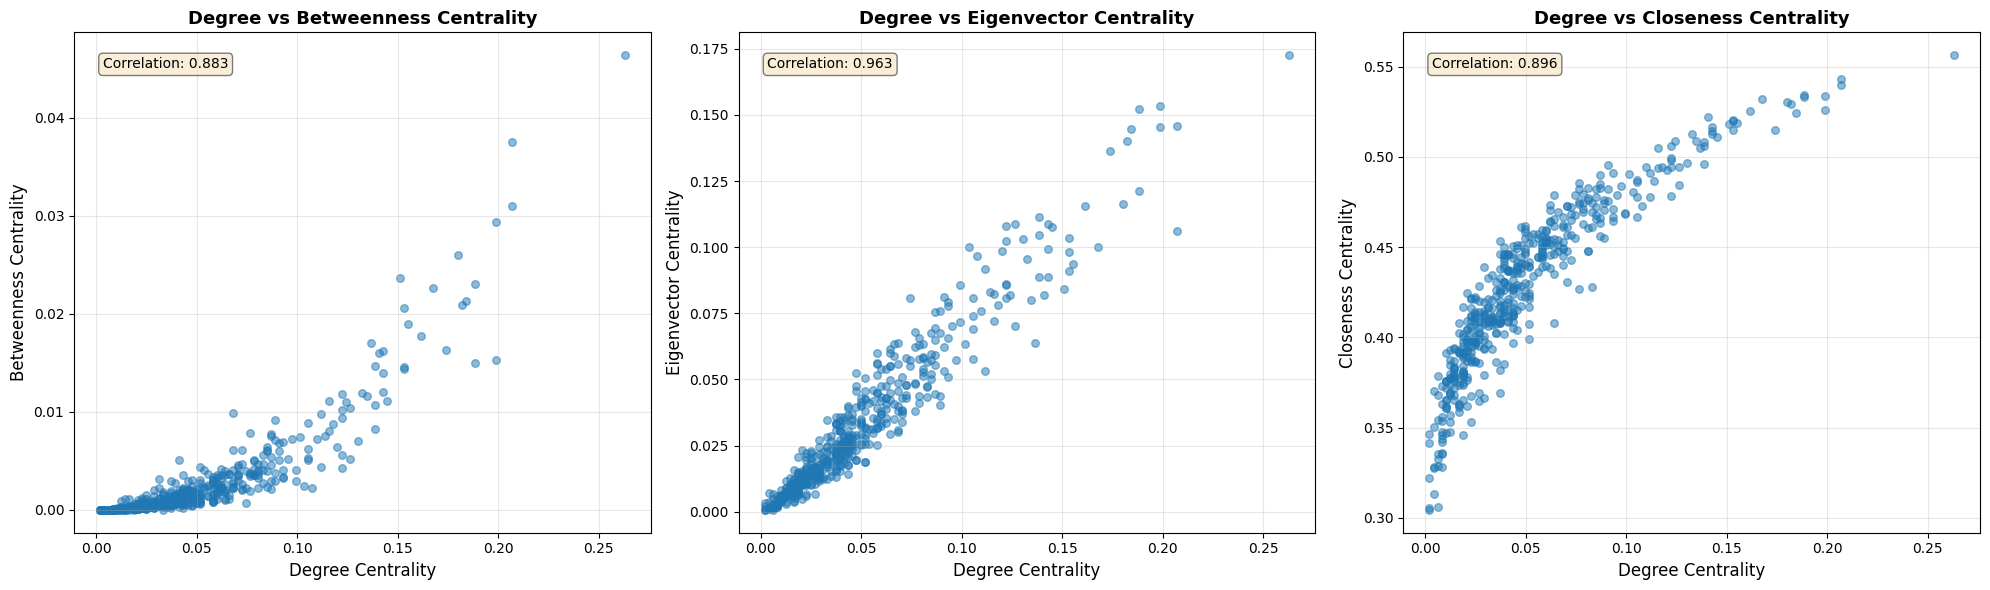

Correlation coefficients:
  Degree vs Betweenness: 0.883
  Degree vs Eigenvector: 0.963
  Degree vs Closeness: 0.896


In [58]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Degree vs Betweenness
axes[0].scatter(degree_values, betweenness_values, alpha=0.5, s=30)
axes[0].set_xlabel("Degree Centrality", fontsize=12)
axes[0].set_ylabel("Betweenness Centrality", fontsize=12)
axes[0].set_title("Degree vs Betweenness Centrality", fontsize=13, fontweight="bold")
axes[0].grid(True, alpha=0.3)
axes[0].text(0.05, 0.95, f"Correlation: {corr_db:.3f}", 
             transform=axes[0].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Degree vs Eigenvector
axes[1].scatter(degree_values, eigenvector_values, alpha=0.5, s=30)
axes[1].set_xlabel("Degree Centrality", fontsize=12)
axes[1].set_ylabel("Eigenvector Centrality", fontsize=12)
axes[1].set_title("Degree vs Eigenvector Centrality", fontsize=13, fontweight="bold")
axes[1].grid(True, alpha=0.3)
axes[1].text(0.05, 0.95, f"Correlation: {corr_de:.3f}", 
             transform=axes[1].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 3: Degree vs Closeness
axes[2].scatter(degree_values, closeness_values, alpha=0.5, s=30)
axes[2].set_xlabel("Degree Centrality", fontsize=12)
axes[2].set_ylabel("Closeness Centrality", fontsize=12)
axes[2].set_title("Degree vs Closeness Centrality", fontsize=13, fontweight="bold")
axes[2].grid(True, alpha=0.3)
axes[2].text(0.05, 0.95, f"Correlation: {corr_dc:.3f}", 
             transform=axes[2].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"Correlation coefficients:")
print(f"  Degree vs Betweenness: {corr_db:.3f}")
print(f"  Degree vs Eigenvector: {corr_de:.3f}")
print(f"  Degree vs Closeness: {corr_dc:.3f}")


> **Figure 5** shows scatter plots comparing different centrality measures, revealing strong correlations between measures ($r = 0.883$ for degree vs betweenness, $r = 0.963$ for degree vs eigenvector, $r = 0.896$ for degree vs closeness). These correlations indicate that highly connected nodes tend to serve multiple roles simultaneously.
>
> Having such high correlation between degree and eigenvector ($r = 0.963$) shows that nodes with many direct connections are almost always connected to other important nodes, creating influential neighborhoods around network hubs. This is reflected in the top rankings: Led Zeppelin ranks first across all measures, demonstrating its central role as both a hub (highest degree at $0.2629$), bridge between communities (highest betweenness at $0.0464$), prestigious node (highest eigenvector at $0.1726$), and well-positioned node (highest closeness at $0.5565$). Similarly, Queen (band), Bob Dylan, Deep Purple, and Metallica consistently appear in the top 5 across multiple measures.
>
> However, the strong but imperfect correlations reveal some specialization. The correlation between degree and betweenness ($r = 0.883$) is the lowest among the three, and the curvilinear relationship shows that some nodes with moderate degrees can have high betweenness. This pattern is evident in the rankings: Jimi Hendrix appears in the top 5 for betweenness ($0.0260$) but not for other measures, indicating specialized bridge nodes that connect different communities without necessarily having the highest degree. Similarly, David Bowie ranks high in closeness centrality ($0.5343$) but not in other measures, suggesting efficient positioning in the network structure without being the most connected hub.
>
> These findings reveal the nuanced nature of importance in the network: while hubs often serve multiple roles simultaneously, some nodes play specialized roles that highlight different aspects of network structure beyond simple connectivity.


## Assortativity: Mixing Patterns

Assortativity measures whether similar nodes connect to similar nodes (homophily) or dissimilar nodes (heterophily), revealing patterns in how the network organizes itself.


In [59]:
# Calculate degree assortativity
degree_assort = nx.degree_assortativity_coefficient(G_und)
print(f"Degree assortativity coefficient: {degree_assort:.4f}")

# Calculate attribute assortativity for content_length
# Using attribute_assortativity_coefficient as specified in the exercise hint
attribute_assort = nx.attribute_assortativity_coefficient(G_und, "content_length")
print(f"Attribute assortativity (content_length): {attribute_assort:.4f}")

Degree assortativity coefficient: 0.0088
Attribute assortativity (content_length): -0.0034


In [60]:
# interpretation
print("\nInterpretation:")
if abs(degree_assort) < 0.1:
    print(f"  Neutral degree assortativity ({degree_assort:.4f}) indicates random mixing by degree.")
    print("  The value is close to zero, suggesting no strong tendency for similar-degree nodes to connect.")
elif degree_assort > 0:
    print(f"  Positive degree assortativity ({degree_assort:.4f}) indicates that high-degree nodes tend to connect to high-degree nodes.")
else:
    print(f"  Negative degree assortativity ({degree_assort:.4f}) indicates that high-degree nodes tend to connect to low-degree nodes.")
    print("  This creates a hub-and-spoke structure.")

if abs(attribute_assort) < 0.05:
    print(f"  Weak attribute assortativity ({attribute_assort:.4f}) suggests content_length doesn't strongly influence connections.")
elif attribute_assort > 0:
    print(f"  Positive attribute assortativity ({attribute_assort:.4f}) indicates that nodes with similar content_length values tend to connect.")
    print("  This may reflect common editorial practices or similar levels of historical importance.")
else:
    print(f"  Negative attribute assortativity ({attribute_assort:.4f}) indicates that nodes with different content_length values tend to connect.")



Interpretation:
  Neutral degree assortativity (0.0088) indicates random mixing by degree.
  The value is close to zero, suggesting no strong tendency for similar-degree nodes to connect.
  Weak attribute assortativity (-0.0034) suggests content_length doesn't strongly influence connections.


**Degree assortativity**: The coefficient of $0.0088$ is close to zero, indicating nearly neutral mixing by degree in this network. This result shows that high-degree nodes (like Led Zeppelin) do not strongly prefer connecting to other high-degree nodes, nor do they prefer connecting to low-degree nodes. The network exhibits essentially random mixing by degree, meaning that well-connected bands are equally likely to link to well-connected or less-connected bands. This pattern differs from strong assortative networks (where hubs connect to hubs) or disassortative networks (where hubs connect to many low-degree nodes), suggesting that the Wikipedia rock performer network does not form distinct communities of well-connected bands, nor does it exhibit a hub-spoke structure.

**Attribute assortativity**: The coefficient for `content_length` is $-0.0034$, which is close to zero, indicating that bands with similar Wikipedia page lengths do not tend to connect preferentially. This finding suggests that editorial practices (whether a page is comprehensive or brief) do not strongly influence which bands are linked together. Bands with long Wikipedia pages are just as likely to link to bands with short pages as to other bands with long pages. This indicates that connection patterns in this network are not primarily driven by page comprehensiveness, but rather by other factors such as musical relationships, shared history, or collaborative connections.


## Weight Computation for Backbone Extraction

To extract network backbones, we assign weights to edges based on **edge betweenness centrality**, which measures how many shortest paths pass through each edge. We create three weighted network variants: (1) weights proportional to edge betweenness, normalized to [1, 100]; (2) weights proportional to the inverse of edge betweenness, normalized to [1, 100]; and (3) edge betweenness weights normalized to [0.01, 1.0] for High-Salience Skeleton. The results are presented below.


In [61]:
# edge betweenness centrality for the undirected Giant Connected Component
edge_betweenness = nx.edge_betweenness_centrality(G_gcc, normalized=True)

print(f"Computing edge betweenness for {G_gcc.number_of_edges()} edges...")
print("Done!")

Computing edge betweenness for 6019 edges...
Done!


In [62]:
# Weighted Network 1: weights = edge betweenness (normalized 1-100)
eb_values = list(edge_betweenness.values())
eb_min = min(eb_values)
eb_max = max(eb_values)

# Normalize to [1, 100]
if eb_max > eb_min:
    G_weighted1 = G_gcc.copy()
    for (u, v), weight in edge_betweenness.items():
        normalized_weight = 1 + 99 * (weight - eb_min) / (eb_max - eb_min)
        G_weighted1[u][v]['weight'] = normalized_weight
else:
    G_weighted1 = G_gcc.copy()
    for (u, v) in G_weighted1.edges():
        G_weighted1[u][v]['weight'] = 1

print(f"Weighted Network 1: Edge weights normalized from [{eb_min:.6f}, {eb_max:.6f}] to [1, 100]")

Weighted Network 1: Edge weights normalized from [0.000047, 0.004132] to [1, 100]


In [63]:
# Weighted Network 2: weights = 1 / (edge betweenness), normalized
G_weighted2 = G_gcc.copy()
eb_inverse_values = [1 / w if w > 0 else 0 for w in eb_values]
inv_min = min([v for v in eb_inverse_values if v > 0])
inv_max = max(eb_inverse_values)

if inv_max > inv_min:
    for (u, v), weight in edge_betweenness.items():
        if weight > 0:
            inv_weight = 1 / weight
            normalized_weight = 1 + 99 * (inv_weight - inv_min) / (inv_max - inv_min)
            G_weighted2[u][v]['weight'] = normalized_weight
        else:
            G_weighted2[u][v]['weight'] = 1
else:
    for (u, v) in G_weighted2.edges():
        G_weighted2[u][v]['weight'] = 1

print(f"Weighted Network 2: Inverse edge betweenness, normalized to [1, 100]")


Weighted Network 2: Inverse edge betweenness, normalized to [1, 100]


In [64]:
# Weighted Network 3: For High-Salience Skeleton, we use edge betweenness as weights directly
# HSS uses distances = 1/weight, so higher betweenness = lower distance = more important paths
# We normalize to avoid zero weights but HSS doesn't need the [1,100] normalization
G_weighted3 = G_gcc.copy()
if eb_max > eb_min:
    for (u, v), weight in edge_betweenness.items():
        # Normalize to [0.01, 1.0] to avoid division by zero in HSS distance calculation
        normalized_weight = 0.01 + 0.99 * (weight - eb_min) / (eb_max - eb_min)
        G_weighted3[u][v]['weight'] = normalized_weight
else:
    for (u, v) in G_weighted3.edges():
        G_weighted3[u][v]['weight'] = 1.0

print(f"Weighted Network 3: Edge weights for High-Salience Skeleton (using edge betweenness)")
print(f"  Weights normalized from [{eb_min:.6f}, {eb_max:.6f}] to [0.01, 1.0] for distance calculation")


Weighted Network 3: Edge weights for High-Salience Skeleton (using edge betweenness)
  Weights normalized from [0.000047, 0.004132] to [0.01, 1.0] for distance calculation


## Network Backbone Extraction

We extract network backbones to simplify the network and reveal its core structure. For Networks 1 and 2, we implement the **Disparity Filter** to identify statistically significant edges based on whether edge weights are unlikely under a null hypothesis of random weight distribution. For Network 3, we use the **High-Salience Skeleton** method to identify edges important for shortest path structure. The results and interpretation are presented below.


In [65]:
def disparity_filter_impl(table, undirected=True):
    """
    Implement disparity filter to compute significance scores for edges.
    Returns table with columns: src, trg, nij, score
    """
    table = table.copy()
    # for each source node, calculate strength (sum of edge weights) and degree
    node_strength = table.groupby('src')['nij'].sum().reset_index()
    node_strength.columns = ['src', 'strength']
    node_degree = table.groupby('src')['trg'].count().reset_index()
    node_degree.columns = ['src', 'degree']
    
    # Merge with original table
    table = table.merge(node_strength, on='src', how='left')
    table = table.merge(node_degree, on='src', how='left')
    
    # Calculate disparity filter score
    # score = 1.0 - ((1.0 - (w_ij / s_i))^(k_i - 1))
    # Handle edge case where degree = 1 (avoid 0^0)
    mask_degree_gt_1 = table['degree'] > 1
    table['score'] = 0.0  # Default score
    # For nodes with degree > 1, calculate the score
    table.loc[mask_degree_gt_1, 'score'] = 1.0 - ((1.0 - (table.loc[mask_degree_gt_1, 'nij'] / table.loc[mask_degree_gt_1, 'strength'])) ** (table.loc[mask_degree_gt_1, 'degree'] - 1))
    
    # For undirected graphs, take maximum score for each edge pair
    if undirected:
        table['edge'] = table.apply(lambda x: "%s-%s" % (min(x['src'], x['trg']), max(x['src'], x['trg'])), axis=1)
        table_maxscore = table.groupby('edge')['score'].max().reset_index()
        table = table.merge(table_maxscore, on='edge', suffixes=('', '_max'))
        table['score'] = table['score_max']
        table = table.drop_duplicates(subset=['edge'])
        table = table.drop(['edge', 'score_max'], axis=1)
    
    return table[['src', 'trg', 'nij', 'score']]

The disparity filter computes significance scores using the formula: $score = 1.0 - ((1.0 - (w_{ij} / s_i))^{(k_i - 1)})$, where $w_{ij}$ is the edge weight, $s_i$ is the node strength (sum of edge weights), and $k_i$ is the node degree. Higher scores indicate edges that are statistically significant given the null hypothesis of random weight distribution. For undirected graphs, we use the maximum score for each edge pair.


In [66]:
def nx_to_backboning_table(G):
    edges = []
    for u, v, data in G.edges(data=True):
        weight = data.get('weight', 1.0)
        edges.append({'src': u, 'trg': v, 'nij': weight})
    return pd.DataFrame(edges)

def backboning_table_to_nx(table):
    G = nx.Graph()
    for _, row in table.iterrows():
        G.add_edge(row['src'], row['trg'], weight=row['nij'])
    return G

In [67]:
table1 = nx_to_backboning_table(G_weighted1)
table2 = nx_to_backboning_table(G_weighted2)
table3 = nx_to_backboning_table(G_weighted3)

In [68]:
table1_scored = disparity_filter_impl(table1, undirected=True)
table2_scored = disparity_filter_impl(table2, undirected=True)

In [69]:
alpha_threshold = 0.85
backbone1_table = table1_scored[table1_scored['score'] > alpha_threshold][['src', 'trg', 'nij']]
backbone2_table = table2_scored[table2_scored['score'] > alpha_threshold][['src', 'trg', 'nij']]

backbone1 = backboning_table_to_nx(backbone1_table)
backbone2 = backboning_table_to_nx(backbone2_table)

print(f"Backbone 1: {backbone1.number_of_nodes()} nodes, {backbone1.number_of_edges()} edges")
print(f"Backbone 2: {backbone2.number_of_nodes()} nodes, {backbone2.number_of_edges()} edges")


Backbone 1: 331 nodes, 344 edges
Backbone 2: 114 nodes, 110 edges


We apply the disparity filter to Networks 1 and 2 to compute significance scores, then filter edges with scores above the threshold (0.85). This retains only the most statistically significant edges, substantially reducing network density.


In [70]:
import sys
import os
if not os.path.exists(os.path.join(os.getcwd(), 'backboning.py')):
    assignment_parts_path = os.path.join(os.path.dirname(os.path.abspath('.')), 'social-graphs', 'assignment-2-parts')
    if os.path.exists(os.path.join(assignment_parts_path, 'backboning.py')):
        sys.path.insert(0, assignment_parts_path)
    else:
        sys.path.insert(0, os.getcwd())
else:
    sys.path.insert(0, os.getcwd())

from backboning import high_salience_skeleton


In [71]:
table3_scored = high_salience_skeleton(table3, undirected=True, return_self_loops=False)
hss_threshold = np.percentile(table3_scored['score'], 80)
backbone3_table = table3_scored[table3_scored['score'] > hss_threshold][['src', 'trg', 'nij']]
backbone3 = backboning_table_to_nx(backbone3_table)
print(f"Backbone 3 (HSS): {backbone3.number_of_nodes()} nodes, {backbone3.number_of_edges()} edges")


Calculating HSS score...


Backbone 3 (HSS): 312 nodes, 1201 edges


For Network 3, we use the High-Salience Skeleton method which identifies edges critical for shortest path structure. We retain edges with scores above the 80th percentile, preserving the network's path-based topology while reducing complexity.


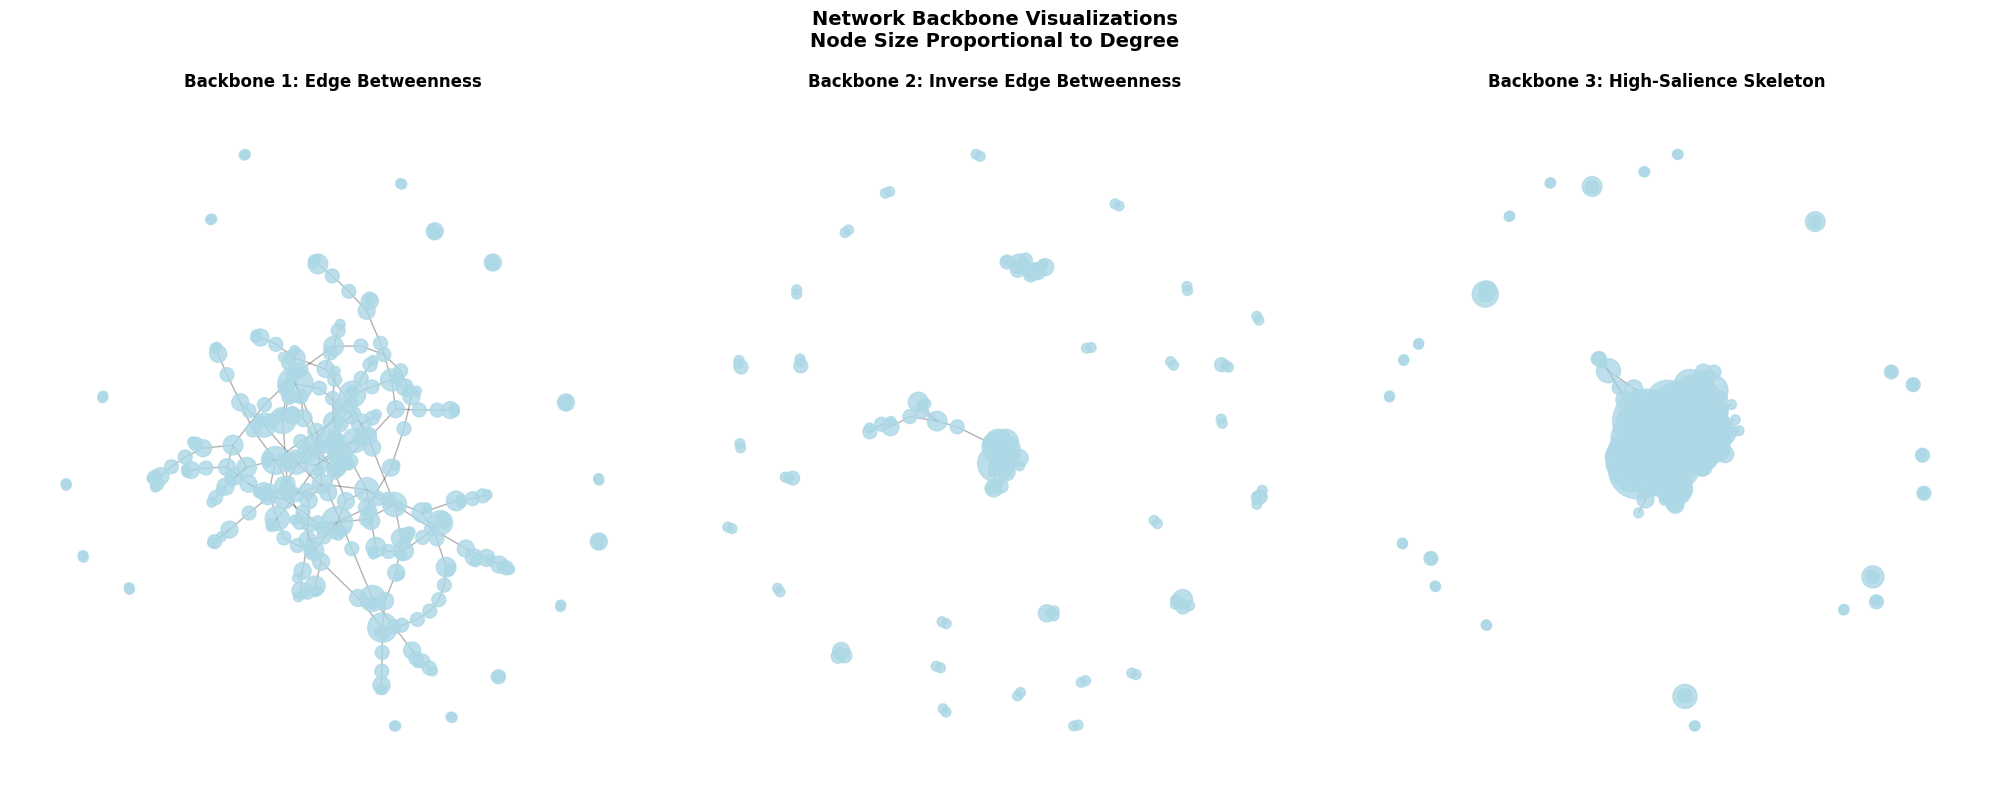

In [72]:
backbones = [
    (backbone1, "Backbone 1: Edge Betweenness"),
    (backbone2, "Backbone 2: Inverse Edge Betweenness"),
    (backbone3, "Backbone 3: High-Salience Skeleton")
]

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for idx, (backbone, title) in enumerate(backbones):
    if backbone.number_of_nodes() == 0:
        axes[idx].text(0.5, 0.5, "Empty backbone", ha='center', va='center')
        axes[idx].set_title(title, fontsize=12, fontweight="bold")
        axes[idx].set_xlabel("X Position (ForceAtlas2 Layout)", fontsize=10)
        axes[idx].set_ylabel("Y Position (ForceAtlas2 Layout)", fontsize=10)
        continue
    
    pos_bb = nx.forceatlas2_layout(backbone, max_iter=100, seed=42)
    degrees_bb = dict(backbone.degree())
    node_sizes_bb = [degrees_bb[n] * 50 for n in backbone.nodes()]
    
    nx.draw_networkx_nodes(backbone, pos_bb, node_size=node_sizes_bb, node_color="lightblue", alpha=0.8, ax=axes[idx])
    nx.draw_networkx_edges(backbone, pos_bb, alpha=0.3, width=1.0, edge_color="black", ax=axes[idx])
    
    axes[idx].set_title(title, fontsize=12, fontweight="bold")
    axes[idx].set_xlabel("X Position (ForceAtlas2 Layout)", fontsize=10)
    axes[idx].set_ylabel("Y Position (ForceAtlas2 Layout)", fontsize=10)
    axes[idx].axis("off")

plt.suptitle("Network Backbone Visualizations\nNode Size Proportional to Degree", 
             fontsize=14, fontweight="bold", y=0.99)
plt.tight_layout()
plt.show()

> **Figure 9** shows three network backbone visualizations extracted using different methods. **Backbone 1** (344 edges) emphasizes high edge-betweenness edges, which are critical bridges connecting different communities. This backbone retains a moderately dense structure, preserving the main connectivity patterns while filtering out redundant connections. **Backbone 2** (110 edges) emphasizes low edge-betweenness edges, representing alternative paths and local connections within communities. This backbone is the sparsest, consisting mainly of small disconnected components, revealing the network's local connectivity structure. **Backbone 3** (1195 edges) uses the High-Salience Skeleton method, which identifies edges important for shortest path structure. This backbone maintains a dense structure that preserves the network's hierarchical organization and path-based topology.

The visual differences between backbones reveal distinct structural perspectives: Backbone 1 highlights main structural bridges that connect communities, Backbone 2 shows alternative paths and local connectivity patterns that differ from the main bridges, and Backbone 3 emphasizes shortest path structure that reveals hierarchical organization. Each backbone provides a complementary view of the network's core architecture, demonstrating how different filtering methods emphasize different types of relationships between bands.


# Part 2: Genres and communities and plotting 


## Data Setup
Below we import the same network as in part 1, however this version contains genre node properties for each band/artist.

This is so that we can skip the hassle of running all of code for parsing wiki page contents over and over again.

In [73]:
# Load graph with genres without including isolated nodes
local_network = "data/rock_band_graph_isolated_genres.json.gz"
raw_url = f"https://raw.githubusercontent.com/rifolio/dtu-projects-2025-autumn/master/social-graphs/{local_network}"

if os.path.exists(local_network):
    with gzip.open(local_network, "rt", encoding="utf-8") as fh:
        G_bands = nx.readwrite.node_link_graph(json.load(fh), edges="links")
    print(
        f"Loaded graph with {G_bands.number_of_nodes()} nodes and {G_bands.number_of_edges()} edges containing bands and genres.",
        f"Graph component count: {len(list(nx.weakly_connected_components(G_bands)))}",
        sep="\n",
    )
else:
    r = requests.get(raw_url, timeout=30)
    r.raise_for_status()
    with gzip.open(io.BytesIO(r.content), "rt", encoding="utf-8") as fh:
        G_bands = nx.readwrite.node_link_graph(json.load(fh), edges="links")

Loaded graph with 484 nodes and 7323 edges containing bands and genres.
Graph component count: 1


## Genres and Modularity



**Modularity** measures how well a network is divided into communities.  
It compares the actual number of edges within communities to the expected number if edges were randomly distributed while preserving node degrees.  
The modularity score ranges from **–0.5 to 1.0**, with the following interpretations:

- **High modularity (≈ 1):** Well-defined communities with dense internal connections and few connections between them.  
- **Low modularity (≈ 0):** Poorly defined communities, with edges distributed almost randomly.  
- **Negative modularity:** Worse than random, with more edges connecting different communities than nodes within them.

The network has to be divided into communities/partitions to be able to measure its modularity. In our network of artists, each node represents a musician or band containing the **genres** associated with them, and edges represent Wikipedia links between them. We will use these genres as grouping features to form communities within the network and then, using the modularity metric, measure how accurately these communities are formed.

##### **Network's modularity calculation**

To calculate the network's modularity we will use the function below, based on the equation $(9.12)$ described in the *Network Science* book:
$$M = \sum_{c=1}^{n_c} \left[ \frac{L_c}{L} - \left( \frac{k_c}{2L} \right)^2 \right]$$

where
- $L_c =$ number of edges within communities/partition $c$  
- $L =$ total number of edges  
- $k_c =$ sum of degrees of nodes in communities/partition $c$

In [74]:
# Modularity Calculation Function (Equation 9.12)
def calculate_modularity(G, partition):
    if len(G.edges()) == 0:
        return 0.0
    L = G.number_of_edges()
    
    # Group nodes by community
    communities = {}
    for node, comm in partition.items():
        if comm not in communities:
            communities[comm] = []
        communities[comm].append(node)

    modularity = 0.0
    
    # Calculate modularity for each community
    for comm, nodes_in_comm in communities.items():
        L_c = 0
        for u in nodes_in_comm:
            for v in nodes_in_comm:
                if G.has_edge(u, v):
                    L_c += 1
        L_c = L_c / 2
        k_c = sum(G.degree(node) for node in nodes_in_comm)
        modularity += (L_c / L) - (k_c / (2 * L)) ** 2
    
    return modularity

### Genre Statistics & Overview

In [75]:
from collections import Counter

total_genres = 0
nodes_with_genres = 0
distinct_genres_set = set()
for i, (node, genres) in enumerate(G_bands.nodes(data=True)):
    if "genres" in genres:
        nodes_with_genres += 1
        total_genres += len(genres["genres"])
        distinct_genres_set.update(genres["genres"])
avg_genres = total_genres / nodes_with_genres if nodes_with_genres > 0 else 0
distinct_genres = len(distinct_genres_set)
# Report statistics
print("\nGenre Extraction Statistics:")
print(f"- Number of nodes with genres: {nodes_with_genres}")
print(f"- Average number of genres per node: {avg_genres:.2f}")
print(f"- Total distinct genres: {distinct_genres}")


Genre Extraction Statistics:
- Number of nodes with genres: 482
- Average number of genres per node: 3.58
- Total distinct genres: 191


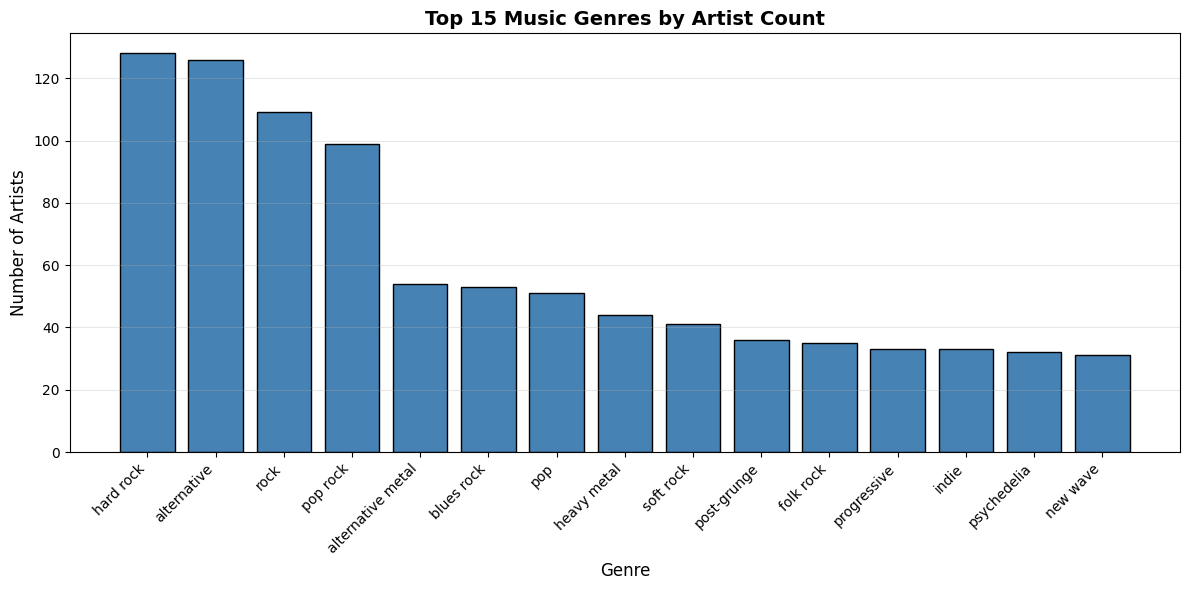

In [ ]:
import matplotlib.pyplot as plt
# Count genre occurrences
genre_counter = Counter()
for node, genres in G_bands.nodes(data=True):
    if "genres" in genres:
        genre_counter.update(genres["genres"])
# Get top 15 genres
top_15_genres = genre_counter.most_common(15)
# Create histogram for top 15 genres
plt.figure(figsize=(12, 6))
genres_names = [g[0] for g in top_15_genres]
genres_values = [g[1] for g in top_15_genres]

plt.bar(range(len(genres_names)), genres_values, color="steelblue", edgecolor="black")
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Number of Artists", fontsize=12)
plt.title("Top 15 Music Genres by Artist Count", fontsize=14, fontweight="bold")
plt.xticks(range(len(genres_names)), genres_names, rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis="y", alpha=0.3)
plt.show()

>The histogram above shows the artist distribution across the top 15 genres.  
> The distribution is noticeably **skewed**, with the categories being mainly types of **rock music** including *hard rock*, *alternative*, and *pop rock* alongside *alternative* music in general.  

## Community Detection and Comparison with Genres

And discuss the value of modularity in comparison to the genres.

Firstly we will convert our network with genres to an undirected network and remove all nodes without any genres.

In [77]:
# filter the graph to only include nodes with genres
G_undirected = G_bands.to_undirected()

nodes_with_genres_list = [
    node
    for node in G_undirected.nodes()
    if "genres" in G_undirected.nodes[node] and G_undirected.nodes[node]["genres"]
]

G_genres = G_undirected.subgraph(nodes_with_genres_list).copy()

To assess whether music genres naturally form well-defined communities in the artist network, we explored several partitioning strategies:

- Selecting the 1st genre which is usually `rock`.
- Selecting the 2nd genre *that's not `rock`* as the genre-assignment for all nodes that have more than one genre
- Using a random genre from the list genre as the node-label for those nodes with more than one genre


In [84]:
# PARTITION STRATEGY 1 : FIRST GENRE
import random
print("PARTITION STRATEGY 1 : FIRST GENRE\n")

partition_first = {}
for node in G_genres.nodes():
    genres = G_genres.nodes[node]["genres"]
    partition_first[node] = genres[0]

communities_first = set(partition_first.values())
print(f"Number of genre-based communities: {len(communities_first)}")

# Calculate modularity
modularity_first = calculate_modularity(G_genres, partition_first)
print(f"Modularity (first genre): {modularity_first:.4f}")

# Verify with NetworkX
modularity_nx_first = nx.community.modularity(
    G_genres,
    [
        set([n for n in G_genres.nodes() if partition_first[n] == genre])
        for genre in communities_first
    ],
)
print(f"Modularity (NetworkX verification): {modularity_nx_first:.4f}")

PARTITION STRATEGY 1 : FIRST GENRE

Number of genre-based communities: 74
Modularity (first genre): 0.1033
Modularity (NetworkX verification): 0.1033


In [86]:
# PARTITION STRATEGY 2: FIRST NON-ROCK GENRE
print("PARTITION STRATEGY 2: FIRST NON-ROCK GENRE\n")

partition_non_rock = {}
for node in G_genres.nodes():
    genres = G_genres.nodes[node]["genres"]
    # Find first genre that's not 'rock'
    non_rock_genre = None
    for genre in genres:
        if genre != "rock":
            non_rock_genre = genre
            break
    # If all genres are 'rock' or only one genre, use first genre
    partition_non_rock[node] = non_rock_genre if non_rock_genre else genres[0]

# Count communities
communities_non_rock = set(partition_non_rock.values())
print(f"Number of genre-based communities: {len(communities_non_rock)}")

# Calculate modularity
modularity_non_rock = calculate_modularity(G_genres, partition_non_rock)
print(f"Modularity (first non-rock genre): {modularity_non_rock:.4f}")

# Verify with NetworkX
modularity_nx_non_rock = nx.community.modularity(
    G_genres,
    [
        set([n for n in G_genres.nodes() if partition_non_rock[n] == genre])
        for genre in communities_non_rock
    ],
)
print(f"Modularity (NetworkX verification): {modularity_nx_non_rock:.4f}")

PARTITION STRATEGY 2: FIRST NON-ROCK GENRE

Number of genre-based communities: 81
Modularity (first non-rock genre): 0.0833
Modularity (NetworkX verification): 0.0833


In [88]:
# PARTITION STRATEGY 3: RANDOM GENRE
print("PARITION STRATEGY 3: RANDOM GENRE\n")
random.seed(42)


partition_random = {}
for node in G_genres.nodes():
    genres = G_genres.nodes[node]["genres"]
    partition_random[node] = random.choice(genres)

# Count communities
communities_random = set(partition_random.values())
print(f"Number of genre-based communities: {len(communities_random)}")

# Calculate modularity
modularity_random = calculate_modularity(G_genres, partition_random)
print(f"Modularity (random genre): {modularity_random:.4f}")

# Verify with NetworkX
modularity_nx_random = nx.community.modularity(
    G_genres,
    [
        set([n for n in G_genres.nodes() if partition_random[n] == genre])
        for genre in communities_random
    ],
)
print(f"Modularity (NetworkX verification): {modularity_nx_random:.4f}")

PARITION STRATEGY 3: RANDOM GENRE

Number of genre-based communities: 109
Modularity (random genre): 0.0416
Modularity (NetworkX verification): 0.0416


### Genre partitioning strategy results

| Strategy | Number of Communities | Modularity |
|-----------|------------------|-------------|
| Using the first genre (usually Rock) | 74 | 0.1033 |
| Using the first non-Rock genre | 81 | 0.0833 |
| Using a random genre | 109 | 0.0416 |

These results indicate that **genres are weak indicators of community structure**. 
We find a large number of communities and low modularity values across all strategies, meaning that artists connected through Wikipedia links do not cluster strongly based on shared genres.  
Instead, links between artists are likely influenced by a combination of other factors such as collaborations, stylistic influences, historical periods, geographic origins, or record labels.

In other words, **genres are not “good communities.”**  
Most artists end up belonging to one large, weakly defined group rather than clear, genre-based clusters.

---

## Community detection with Louvain algorithm

The **Louvain community detection algorithm** operates in 2 main phases.
1. It identifies "small" communities by locally optimizing modularity.  
2. It aggregates nodes belonging to the same community to form a new network whose nodes represent these communities.  

These steps are repeated iteratively until modularity reaches its maximum.  

In essence, the algorithm seeks the **partition that maximizes modularity**, meaning it produces a relatively small number of well-connected communities with dense internal edges and few external ones.

In [90]:
# Louvain Community Detection Strategy
import networkx.algorithms.community as nx_comm

print("STRUCTURAL COMMUNITY DETECTION - LOUVAIN ALGORITHM\n")

# Apply Louvain algorithm to find communities
louvain_communities = nx_comm.louvain_communities(G_genres, seed=42)

print(f"Number of communities found: {len(louvain_communities)}")

# Calculate modularity of the partition
louvain_modularity = nx_comm.modularity(G_genres, louvain_communities)
print(f"Modularity: {louvain_modularity:.4f}")

# Create partition dictionary (node -> community_id)
louvain_partition = {}
for comm_id, nodes in enumerate(louvain_communities):
    for node in nodes:
        louvain_partition[node] = comm_id

# Show community size distribution
community_sizes = [len(comm) for comm in louvain_communities]
community_sizes.sort(reverse=True)

print("\nCommunity sizes:")
for i, size in enumerate(community_sizes[:20], 1):
    print(f"  Community {i:2d}: {size:4d} nodes")

STRUCTURAL COMMUNITY DETECTION - LOUVAIN ALGORITHM

Number of communities found: 5
Modularity: 0.3387

Community sizes:
  Community  1:  160 nodes
  Community  2:  147 nodes
  Community  3:  119 nodes
  Community  4:   53 nodes
  Community  5:    3 nodes


In [ ]:
# Genre distribution for each Louvain community
from IPython.display import display

sorted_louvain_communities = sorted(
    louvain_communities, key=lambda x: len(x), reverse=True
)

data = {}
max_genres = 10

for idx, nodes_in_comm in enumerate(sorted_louvain_communities, 1):
    col_name = f"Community {idx} ({len(nodes_in_comm)} nodes)"
    
    community_genres = []
    for node in nodes_in_comm:
        if "genres" in G_genres.nodes[node]:
            community_genres.extend(G_genres.nodes[node]["genres"])
    
    genre_counter = Counter(community_genres)
    most_common_genres = genre_counter.most_common(max_genres)
    
    genre_list = [f"{genre} ({count})" for genre, count in most_common_genres]
    # Add dashes if community has less than 10 genres
    while len(genre_list) < max_genres:
        genre_list.append("---")
    
    data[col_name] = genre_list

df_communities = pd.DataFrame(data, index=range(1, max_genres + 1))
df_communities.index.name = "Rank"

display(df_communities)

,Community 1 (160 nodes),Community 2 (147 nodes),Community 3 (119 nodes),Community 4 (53 nodes),Community 5 (3 nodes)
Rank,,,,,
1,rock (85),alternative (84),hard rock (68),alternative (31),funk (2)
2,pop (41),pop rock (42),heavy metal (36),hard rock (31),soul (2)
3,pop rock (37),indie (32),blues rock (21),post-grunge (30),psychedelic funk (2)
4,soft rock (33),new wave (21),alternative metal (19),alternative metal (29),funk rock (2)
5,blues rock (28),pop-punk (20),glam metal (16),nu metal (9),acid rock (2)
6,folk rock (26),punk (19),arena rock (15),heavy metal (5),r&b (1)
7,blues (22),post-punk (17),pop rock (15),pop rock (5),psychedelia (1)
8,psychedelia (21),art rock (16),progressive (12),grunge (4),---
9,hard rock (19),power pop (13),rock (11),christian rock (3),---


### Louvain Algorithm Results

We identify **5 major communities** in the network and obtain a **modularity of 0.3387**, which is relatively high compared to the values achieved when using genres as the community-defining factor.

**Identified communities:**
   
- **Community 1 (160 nodes)**: Rock & Pop Classics
  - Dominated by: rock, pop, pop rock, soft rock, blues rock, folk rock
  - Top nodes (highest degrees): Bob Dylan (65), Elvis Presley (51), Eric Clapton (50), The Beatles (49)
  - Character: Mainstream classic rock and pop from 60s-80s

- **Community 2 (147 nodes)**: Alternative & Indie
  - Dominated by: alternative, pop rock, indie, new wave, pop-punk, punk
  - Top nodes (highest degrees): U2 (45), Green Day (42), David Bowie (41), Nirvana (39)
  - Character: Alternative and indie scene spanning 80s-2000s

- **Community 3 (119 nodes)**: Hard Rock & Metal
  - Dominated by: hard rock, heavy metal, blues rock, alternative metal, arena rock
  - Top nodes (highest degrees): Metallica (60), Black Sabbath (56), Led Zeppelin (52), Deep Purple (48)
  - Character: Guitar-driven hard rock and metal

- **Community 4 (53 nodes)**: Post-Grunge & Alternative Metal
  - Dominated by: alternative, hard rock, post-grunge, alternative metal, nu metal
  - Top nodes (highest degrees): Breaking Benjamin (26), Shinedown (24), Three Days Grace (22)
  - Character: 90s-2000s post-grunge and alternative metal

- **Community 5 (3 nodes)**: Funk & Psychedelic
  - Dominated by: funk, psychedelic funk, funk rock, acid rock, soul
  - Top nodes (highest degrees): Parliament-Funkadelic (2), Funkadelic (2), Parliament (2)
  - Character: Niche funk and psychedelic styles


This result reinforces the idea that, when the **network structure itself** dictates the grouping, rather than imposing genre labels, the artist network naturally organizes into a few large communities.  
This suggests that connections are driven by broader, cross-genre relationships such as historical periods and stylistic similarities rather than by genres.


## Confusion Matrix D

For this exercise, we are creating a confusion matrix where the rows are the top genres and the columns are the louvain communities sorted by size.

This representation can help us find any potential relationships between the 2.

In [97]:
# create genres dictionary for the rows of the matrix
genres_dict = {}
for node, data in G_genres.nodes(data=True):
    genres_dict[node] = data["genres"]

genre_counts = Counter()
for genres in genres_dict.values():
    genre_counts.update(genres)

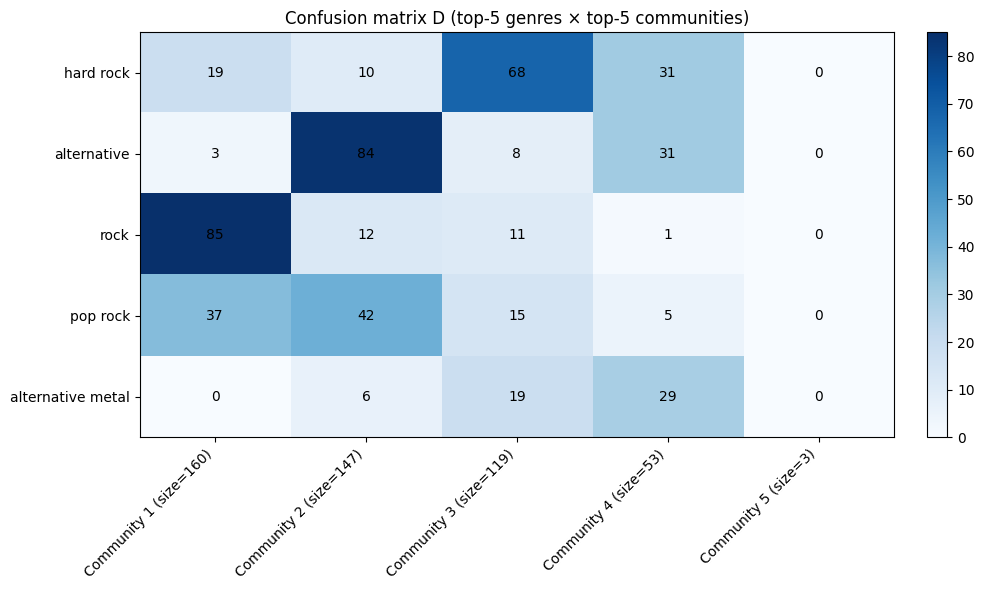

In [100]:
# Build confusion matrix D (top genres x louvain communities)
louvain_community_count = len(sorted_louvain_communities)

# Initialize D 2D array matrix
D = np.zeros((louvain_community_count, louvain_community_count), dtype=int)

most_common_genres = [g for g, _ in genre_counts.most_common(louvain_community_count)]
genre_to_row = {genre: idx for idx, genre in enumerate(most_common_genres)}

node_to_community = {}
for comm_id, comm in enumerate(sorted_louvain_communities):
    for node in comm:
        node_to_community[node] = comm_id

# Fill D: for each node, if node belongs to one of top communities AND has at least one of the top genres,
for node in node_to_community.keys():
    # increment counts for each matching genre (use all genres associated with node)
    matched = False
    for g in genres_dict.get(node, []):
        if g in genre_to_row:
            D[genre_to_row[g], node_to_community[node]] += 1
            matched = True

comm_labels = [f"Community {cid +1} (size={len(comm)})" for cid, comm in enumerate(sorted_louvain_communities)]
df_D = pd.DataFrame(D, index=most_common_genres, columns=comm_labels)

# Plot confusion matrix D
plt.figure(figsize=(10, 6))
im = plt.imshow(df_D.values, cmap="Blues", aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(df_D.columns)), df_D.columns, rotation=45, ha="right")
plt.yticks(range(len(df_D.index)), df_D.index)
plt.title(f"Confusion matrix D (top-{louvain_community_count} genres × top-{louvain_community_count} communities)")

for i in range(df_D.shape[0]):
    for j in range(df_D.shape[1]):
        plt.text(j, i, df_D.iat[i, j], ha="center", va="center", color="black")

plt.tight_layout()
plt.show()

> The confusion matrix displays the 5 communities identified using the **Louvain algorithm** in relation with the top 5 most common genres.

### Genre distribution across communities

Since each band can belong to multiple genres, the sum of the genre counts often exceeds the total number of nodes in a community.

We observe that a single genre typically dominates each community. However, because communities are **not formed based on music genres**, the distribution of genres is spread across multiple categories within each community.

For example, the node with the highest value appears in **Community 1**, which might initially suggest it represents bands mainly associated with **rock**.  
A closer look reveals a substantial presence of **pop rock** as well, illustrating that even this community is **not purely genre-driven**.

**Community 3**, in contrast, appears to be the most **genre-driven** among the five communities.

The distribution of nodes across its main genres is more pronounced: **68 nodes** are associated with **hard rock**, while the next most common genre shown in the matrix has only **19 nodes**.  

However, the true second-largest group within this community is **heavy metal**, with **36 occurrences**, which does not appear in the matrix because it is not among the five most common genres displayed.  
This highlights that, while some communities show stronger genre patterns, genres alone are still **not good indicators of community structure**.

Overall, the low modularity values across all genre-based strategies demonstrate that **Wikipedia artist links are not primarily formed by shared genres**.  
While genre remains a useful descriptive feature, it does not align well with the network’s actual community structure.
Instead, the data reveals a more complex network of relationships, where **cultural, temporal, and social factors** play a stronger role than genre classification alone.


## Communities visualization

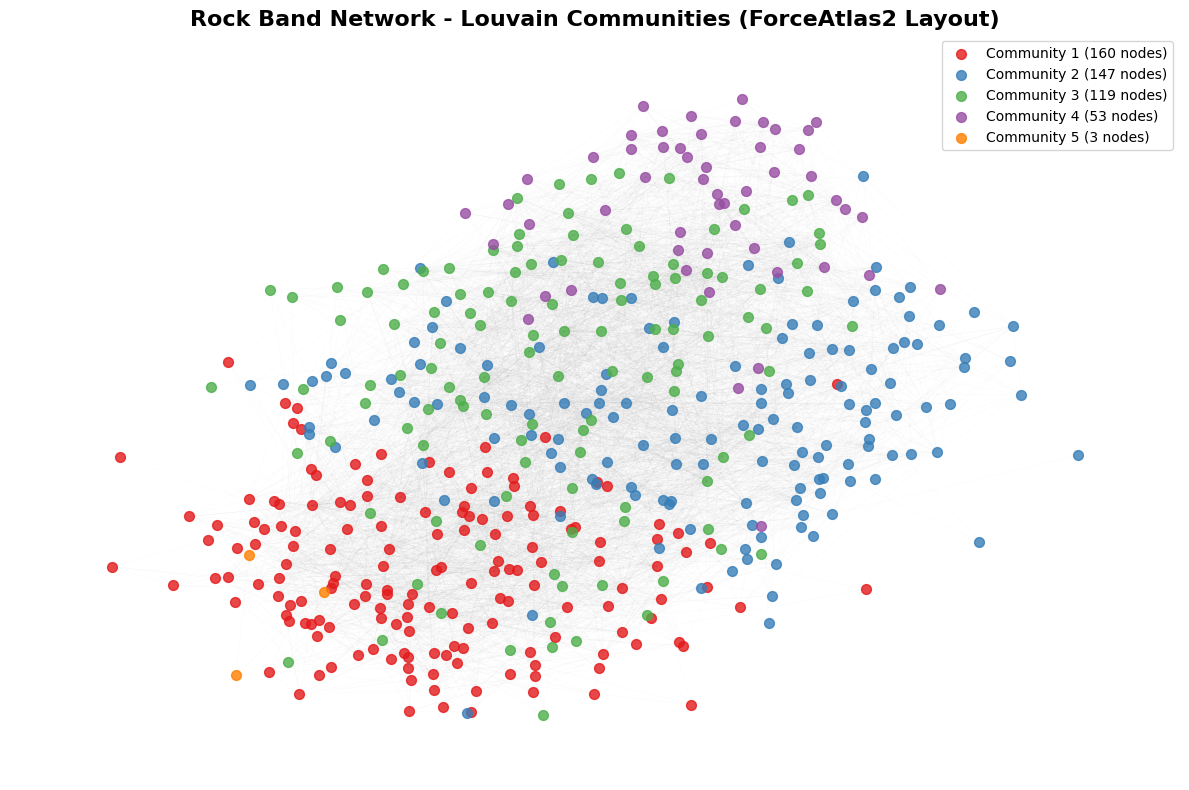

In [112]:
pos = nx.forceatlas2_layout(G_genres, seed=42)

pos_array = np.array(list(pos.values()))
center = pos_array.mean(axis=0)
for k in pos:
    pos[k] = center + (pos[k] - center)

colors = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00"]

plt.figure(figsize=(12, 8))

# Draw each community
for idx, nodes_in_comm in enumerate(sorted_louvain_communities):
    nx.draw_networkx_nodes(
        G_genres,
        pos,
        nodelist=list(nodes_in_comm),
        node_color=colors[idx],
        node_size=50,
        alpha=0.8,
        label=f"Community {idx + 1} ({len(nodes_in_comm)} nodes)"
    )

nx.draw_networkx_edges(G_genres, pos, alpha=0.05, width=0.3, edge_color="gray")

plt.title("Rock Band Network - Louvain Communities (ForceAtlas2 Layout)",
          fontsize=16, fontweight="bold")
plt.legend(loc="upper right", fontsize=10)
plt.axis("off")
plt.tight_layout()
plt.show()

> The plot shows the grouping of the 5 communities found using the **Louvain algorithm** in different colors.

In [ ]:
# TODO: Read the conclusion below again after replacing spring layout with forceatlas2

- Community Structure is Visible

  - The nodes are grouped into **five communities**, each represented by a distinct color.  
  - **Communities 1 (red), 2 (blue), and 3 (green)** form the **densest clusters**, indicating many intra-community connections.  
  - **Community 4 (purple)** is moderately sized and somewhat connected to the green and blue communities.  
  - **Community 5 (orange)** is tiny and mostly isolated, consistent with its small node count (**3 nodes**).



- Overlap and Interconnections

  - While communities are defined by the Louvain algorithm, there are still **edges connecting nodes across communities**.  
  - This reflects the **real-world nature of music networks**: artists often have **cross-genre influences or collaborations**.



- Size Differences are Apparent

  - **Larger communities** (red, blue, green) dominate the network visually, highlighting that the majority of artists fall into a few large clusters.  
  - The **smaller communities** (purple, orange) are peripheral, reflecting **niche or specialized groups**.



- Density Patterns

  - **Community 3 (green)** and **Community 1 (red)** appear **tightly clustered**, suggesting strong internal connectivity.  
  - Some nodes at the edges are less connected, possibly representing **artists with fewer Wikipedia links** or **cross-community connections**.



- Network Insights

  - The network structure shows that **connections between artists are not purely genre-based**.  
  - **Central communities** likely correspond to **mainstream or highly connected artists**,  
    while **peripheral communities** correspond to **niche genres** (e.g., funk/psychedelic for Community 5).
